# Testing FOOOF with Simulated Data

This notebook synthesizes synthetic power spectra, and tests FOOOF's performance on them.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [3]:
# Import project specific (local) custom code
%autoreload 2
from syn_utils import *
from syn_plts import *

In [4]:
# Set random seed
import random
random.seed(333)

In [5]:
# Set plotting style from seaborn
sns.set_style('white')

## Settings

In [6]:
# General Simulation Settings
f_range = [2, 40]
f_res = 0.25

In [7]:
# Plot Settings
save_fig = True

## Check Generation

In [8]:
# Test generate a power spectrum
ap = [0, 1]
osc = [10, 0.5, 2]
nlv = 0.

fs, ps = gen_power_spectrum(f_range, ap, osc, nlv, f_res)

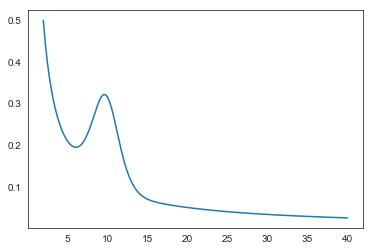

In [9]:
# Plot example synthesized power spectrum
plt.plot(fs, ps)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0151, 1.0095                                          
                                                                                                  
                                       1 peaks were found:                                        
          

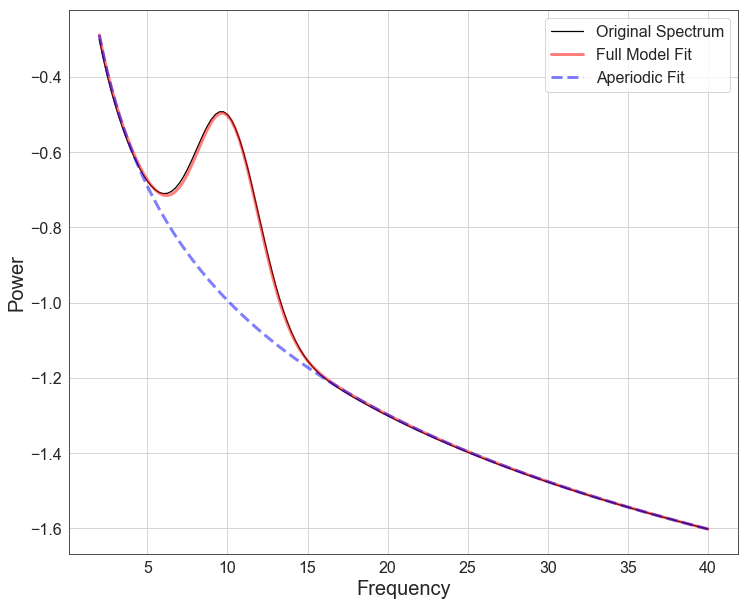

In [10]:
fm = FOOOF()
fm.report(fs, ps, plt_log=False)

In [11]:
# Compare actual parameters to FOOOF fit
print(ap, '\t', fm.aperiodic_params_)
print(osc, '\t', fm.gaussian_params_)

[0, 1] 	 [0.01505844 1.00946517]
[10, 0.5, 2] 	 [[10.02088734  0.49164941  1.92918988]]


## Synthetic Generation Settings

Settings to be used in the synthetic generation are all defined in syn_utils. 

Here we will just check the settings that are being used. 

In [12]:
print_settings(N_OSCS_OPTS, N_OSCS_PROBS, '# of oscs')

Parameter definition for # of oscs 

	Value 	 Probability
	0 	 33.3%
	1 	 33.3%
	2 	 33.3%


In [13]:
print_settings(CF_OPTS, CF_PROBS, 'CFs')

Parameter definition for CFs 

	Value 	 Probability
	3 	 0.9%
	4 	 1.1%
	5 	 3.0%
	6 	 5.2%
	7 	 4.1%
	8 	 4.7%
	9 	 6.9%
	10 	 9.1%
	11 	 6.0%
	12 	 3.6%
	13 	 3.0%
	14 	 2.8%
	15 	 3.1%
	16 	 3.1%
	17 	 3.4%
	18 	 4.2%
	19 	 4.7%
	20 	 3.9%
	21 	 5.0%
	22 	 5.0%
	23 	 2.9%
	24 	 2.8%
	25 	 2.7%
	26 	 2.2%
	27 	 2.0%
	28 	 1.5%
	29 	 1.0%
	30 	 0.7%
	31 	 0.4%
	32 	 0.3%
	33 	 0.3%
	34 	 0.2%


In [14]:
print_settings(PW_OPTS, PW_PROBS, 'PWs')

Parameter definition for PWs 

	Value 	 Probability
	0.15 	 25.0%
	0.2 	 25.0%
	0.25 	 25.0%
	0.4 	 25.0%


In [15]:
print_settings(BW_OPTS, BW_PROBS, 'BWs')

Parameter definition for BWs 

	Value 	 Probability
	1.0 	 33.3%
	2.0 	 33.3%
	3.0 	 33.3%


In [16]:
print_settings(OFF_OPTS, OFF_PROBS, 'aperiodic offset')

Parameter definition for aperiodic offset 

	Value 	 Probability
	0 	 100.0%


In [17]:
print_settings(EXP_OPTS, EXP_PROBS, 'aperiodic slope')

Parameter definition for aperiodic slope 

	Value 	 Probability
	0.5 	 25.0%
	1 	 25.0%
	1.5 	 25.0%
	2 	 25.0%


In [18]:
# Sanity check probabilities are set correctly
for probs in [CF_PROBS, PW_PROBS, BW_PROBS, OFF_PROBS, EXP_PROBS]:
    assert np.isclose(sum(probs), 1, 1e-10)
print('All probabilities check out.')

All probabilities check out.


## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well we can reconstruct each variable.

### Simulate Power Spectra

In [19]:
# Set the number of PSDs - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = gen_osc_def(1)
aps = gen_ap_def()

In [20]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [21]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
op_sim_params = [None] * n_nlvs

for n_ind, nlv in enumerate(nlvs):
    freqs, psds[n_ind, :, :], op_sim_params[n_ind] = \
        gen_group_power_spectra(n_psds, f_range, aps, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [22]:
# Extract ground truth values
osc_truths, ap_truths = get_ground_truth(op_sim_params)

##### Check the empirical levels of noise expected  (empirical noise floor)

These should be, and are, the same as the noise scaling factor. This just checks the estimate error on that, given the number of simulations. These values then set the amount of variance that can be expected to be captured by FOOOF - and if it captures more than this, we know that it is overfitting. 

In [23]:
emp_nlv = []
for nlv in nlvs:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(fs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [24]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(nlvs)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0249', '0.0500', '0.0997', '0.1503']


### Fit Power Spectra with FOOOF

In [25]:
# Initialize FOOOFGroup to test with
op_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, verbose=False)

# Print out settings used to syntethetic fitting - one peak
op_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.0                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [26]:
# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
op_fgs = fit_fooof_group_3d(op_fg, freqs, psds)

In [27]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of synthetic power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

### Extract FOOOF fit Data

In [28]:
# Extract data of interest from FOOOF fits
osc_fits, ap_fits, err_fits, r2_fits, n_oscs = get_fit_data(op_fgs)

In [29]:
# Calculate error
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
ap_errors = np.abs(ap_truths - ap_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#ap_errors = (ap_truths - ap_fits)**2

In [30]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
pw_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

### Check Average Errors & Stats

In [31]:
datas = [cf_errors, pw_errors, bw_errors, off_errors, exp_errors, err_fits, r2_fits]
labels = ['CF', 'PW', 'BW', 'OFF', 'EXP', 'ERR', 'R^2']
for dat, label in zip(datas, labels):
    print(label)
    print('\t', np.nanmedian(dat, 1))

CF
	 [0.00531832 0.2073685  0.38705047 0.74071185 1.13257036]
PW
	 [0.00276223 0.01359015 0.02575958 0.05188403 0.10180034]
BW
	 [0.05323374 0.26598186 0.5        1.         1.        ]
OFF
	 [0.00134226 0.01301721 0.02570965 0.04791075 0.07001912]
EXP
	 [0.00142305 0.01082878 0.02103301 0.03887561 0.05669223]
ERR
	 [0.0013337  0.01923492 0.03843777 0.07730017 0.11648788]
R^2
	 [0.99998305 0.9964479  0.98784254 0.94452172 0.8795277 ]


In [32]:
print('Correlations of median error with noise level:')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(*spearmanr(nlvs, np.nanmedian(cf_errors, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(*spearmanr(nlvs, np.nanmedian(pw_errors, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(*spearmanr(nlvs, np.nanmedian(bw_errors, axis=1))))

print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(*spearmanr(nlvs, np.nanmedian(off_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(*spearmanr(nlvs, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:
	CF	: 1.000 	0.00
	PW	: 1.000 	0.00
	BW	: 0.975 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


### Create Plots

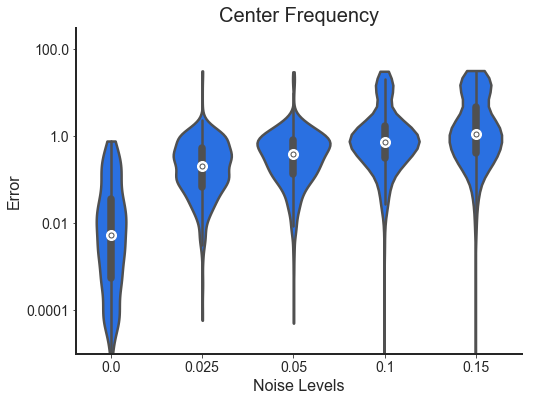

In [33]:
plot_errors_violin(cf_errors, 'Center Frequency',
                   plt_log=True, y_label=None, ylim=[-5, 2.5],
                   save_fig=save_fig, save_name='1Peak-CF')

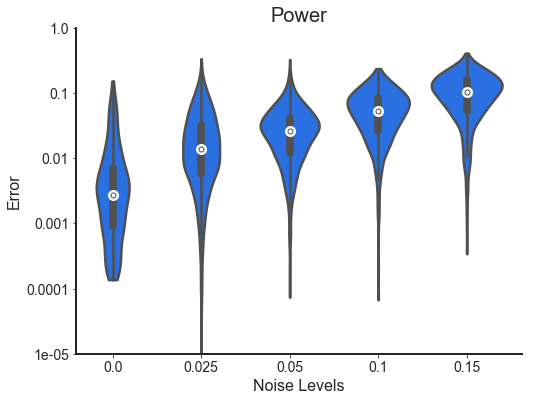

In [34]:
plot_errors_violin(pw_errors, 'Power',
                   plt_log=True, y_label=None, ylim=[-5, 0],
                   save_fig=save_fig, save_name='1Peak-PW')

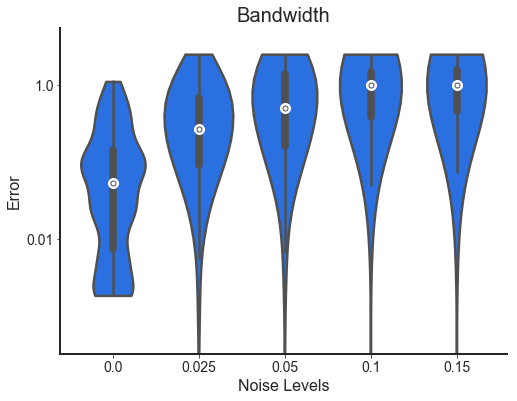

In [35]:
plot_errors_violin(bw_errors, 'Bandwidth',
                   plt_log=True, y_label=None, ylim=[-3.5, 0.75],
                   save_fig=save_fig, save_name='1Peak-BW')

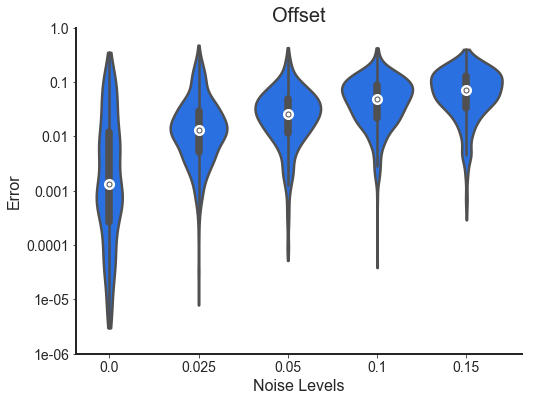

In [36]:
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, y_label=None,
                   save_fig=save_fig, save_name='1Peak-Off')

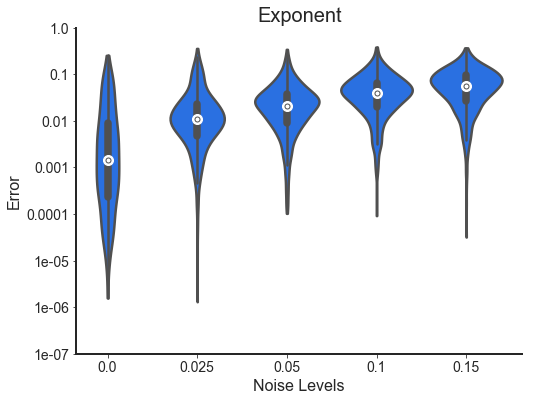

In [37]:
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, y_label=None,
                   save_fig=save_fig, save_name='1Peak-Exp')

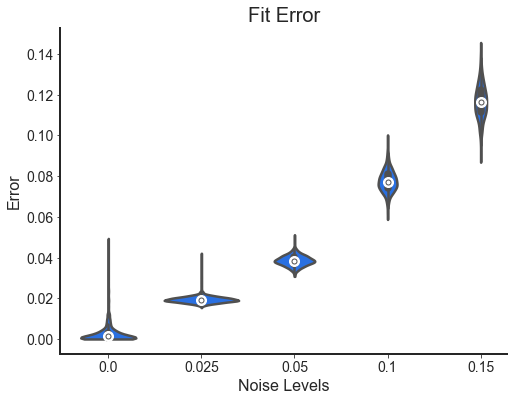

In [38]:
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   y_label='Error',
                   save_fig=save_fig, save_name='1Peak-Err')

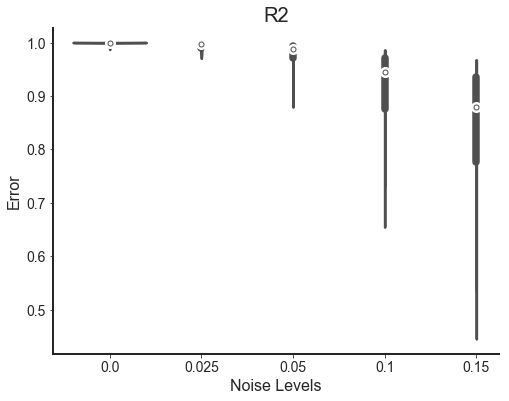

In [39]:
plot_errors_violin(r2_fits, 'R2', plt_log=False, y_label=None,
                   save_fig=save_fig, save_name='1Peak-R2')

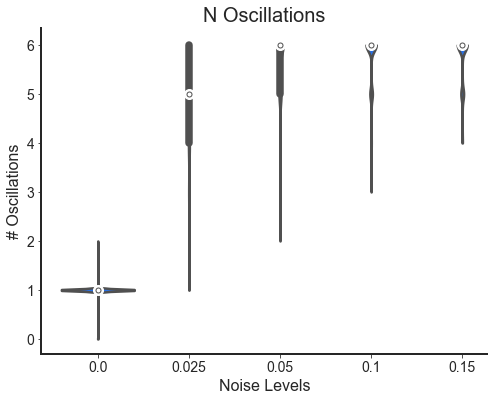

In [40]:
plot_errors_violin(n_oscs, 'N Oscillations', y_label='# Oscillations', 
                   save_fig=save_fig, save_name='1Peak_#Oscs')

In [41]:
# Explore fitting linear model across noise levels, checking the slope and fit error

# from scipy.stats import spearmanr
# from scipy.stats import linregress

# nlvs_cont = np.array([nlv * np.ones(shape=[1, 1000]) for nlv in nlvs]).flatten()
# temp = cf_errors.flatten()
# keep_inds = ~np.isnan(temp)

# slope, intercept, r_value, p_value, std_err = linregress(nlvs_cont[keep_inds],
#                                                          temp[keep_inds])
# print(r_value**2)

# Explore checking the correlation of median error with noise levels
# print(spearmanr(nlvs, np.nanmedian(cf_errors, 1)))

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 1.5], gaussian_params=[[11, 0.4, 2.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0085, 1.5051                                          
                                                                                                  
                             

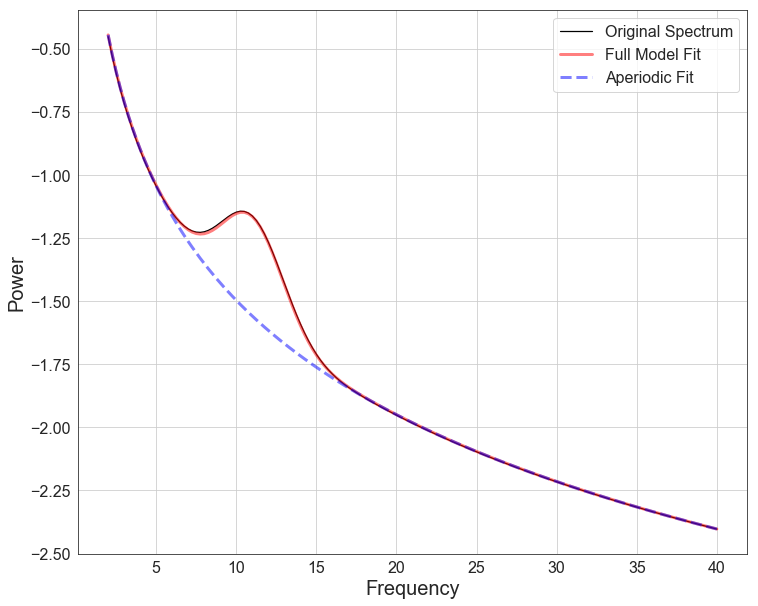

In [42]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = op_fgs[0].get_fooof(ind, True)
print(op_sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=save_fig, file_path='plts', file_name='1Peak-NLV1')

SimParams(aperiodic_params=[0, 0.5], gaussian_params=[[17, 0.2, 3.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.0469, 0.5075                                          
                                                                                                  
                            

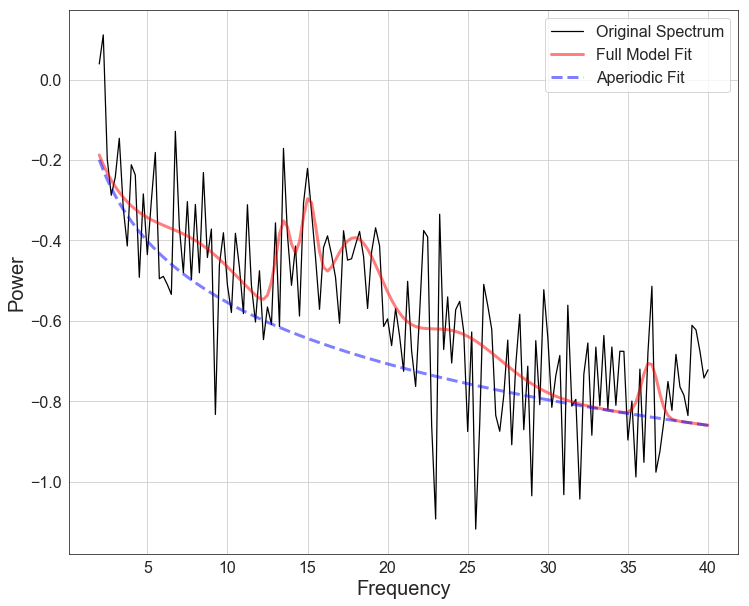

In [43]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = op_fgs[-1].get_fooof(ind, True)
print(op_sim_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=save_fig, file_path='plts', file_name='1Peak-NLV5')

In [44]:
# Collect info for averages across all simulations
r2_fits_1p = r2_fits

## Simulation Tests: Multiple Peaks

Next, simulate power spectra with variable numbers of peaks, and test fitting on them. 

### Simulate Power Spectra

In [45]:
# Set the number of PSDs - this is per n_osc condition
n_psds = 1000

# Set the noise levels to use
n_oscs = [0, 1, 2, 3, 4]
nlv = 0.01
#nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = []
for n_osc in n_oscs:
    peaks.append(gen_osc_def(n_osc))
aps = gen_ap_def()

In [46]:
# Get data sizes
n_n_oscs = len(n_oscs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [47]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_n_oscs, n_psds, n_freqs])
mp_sim_params = [None] * n_n_oscs

#for n_ind, n_osc in enumerate(n_oscs):
for n_ind, n_osc, peaks in zip(range(n_n_oscs), n_oscs, peaks):
    freqs, psds[n_ind, :, :], mp_sim_params[n_ind] = \
        gen_group_power_spectra(n_psds, f_range, aps, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [48]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(mp_sim_params)

In [49]:
# Initialize FOOOFGroup to test with
mp_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.1)

# Check settings for FOOOF used to fit multiple peak simulations
mp_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [50]:
# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
mp_fgs = fit_fooof_group_3d(mp_fg, freqs, psds)

Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.


In [51]:
# Extract data of interest from FOOOF fits
_, ap_fits, err_fits, r2_fits, n_fit_oscs = get_fit_data(mp_fgs)

# Calculate error
ap_errors = np.abs(ap_truths - ap_fits)

### Create Plots

In [52]:
np.mean(err_fits, 1)

array([0.00792971, 0.00889678, 0.01065197, 0.01296776, 0.01585667])

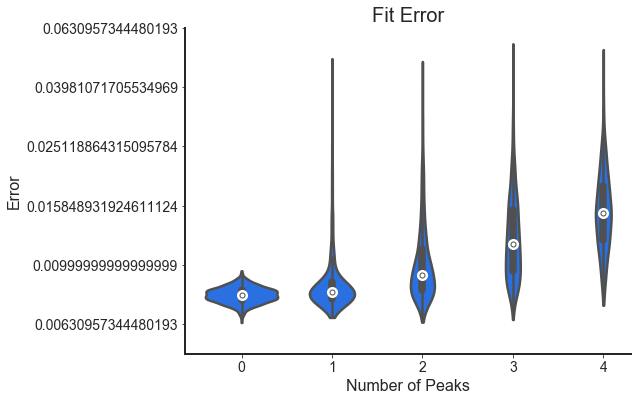

In [53]:
# Multi-peak fitting: plot error as you simulate extra peaks
plot_errors_violin(err_fits, 'Fit Error',
                   x_axis='n_oscs', plt_log=True, ylim=[-2.3, -1.2],
                   save_fig=save_fig, save_name='MPeak-Err')

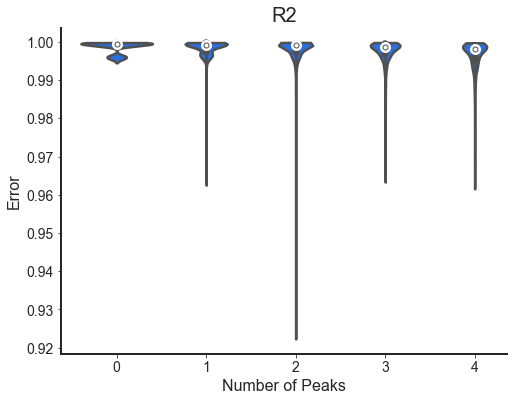

In [54]:
plot_errors_violin(r2_fits, 'R2', x_axis='n_oscs', plt_log=False)

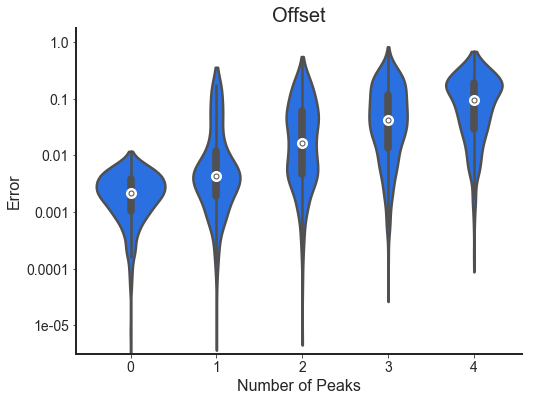

In [55]:
plot_errors_violin(ap_errors[:, :, 0], 'Offset',
                   x_axis='n_oscs', plt_log=True, ylim=[-5.5, 0.25])

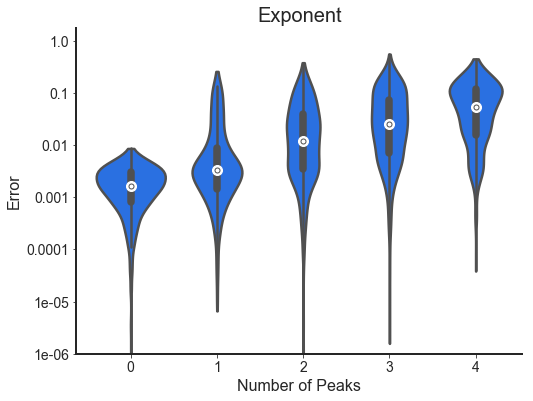

In [56]:
plot_errors_violin(ap_errors[:, :, 1], 'Exponent',
                   x_axis='n_oscs', plt_log=True, ylim=[-6, 0.25])

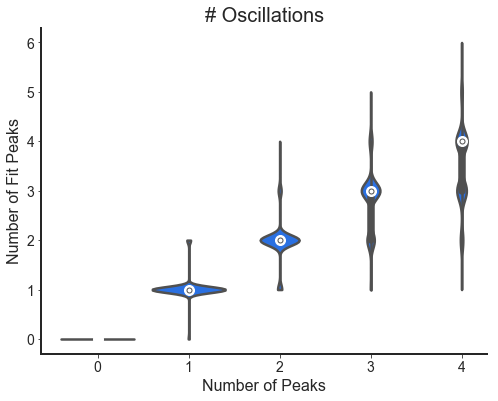

In [57]:
plot_errors_violin(n_fit_oscs, '# Oscillations', x_axis='n_oscs', y_label='Number of Fit Peaks')

In [58]:
# Grab all data for number of peaks simulated
n_actual_oscillations = []
for n in n_oscs:
    n_actual_oscillations.append([n] * n_psds)
n_actual_oscillations = np.array(n_actual_oscillations)
n_actual_oscillations = n_actual_oscillations.flatten()

# Grab data for number of peaks fit
n_fit_oscs = n_fit_oscs.flatten()

# Collect together # simulated & # fit, for plotting
dat = []
for a, b in zip(n_actual_oscillations, n_fit_oscs):
    dat.append((a, b))
n_osc_counter = Counter(dat)

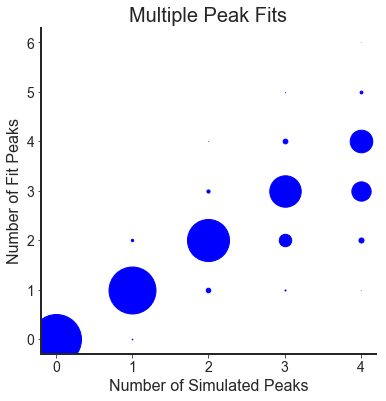

In [59]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_oscs_bubbles(n_osc_counter, True)

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 2.0], gaussian_params=[[6, 0.4, 1.0], [15, 0.2, 1.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0169, 2.0110                                          
                                                                                                  
             

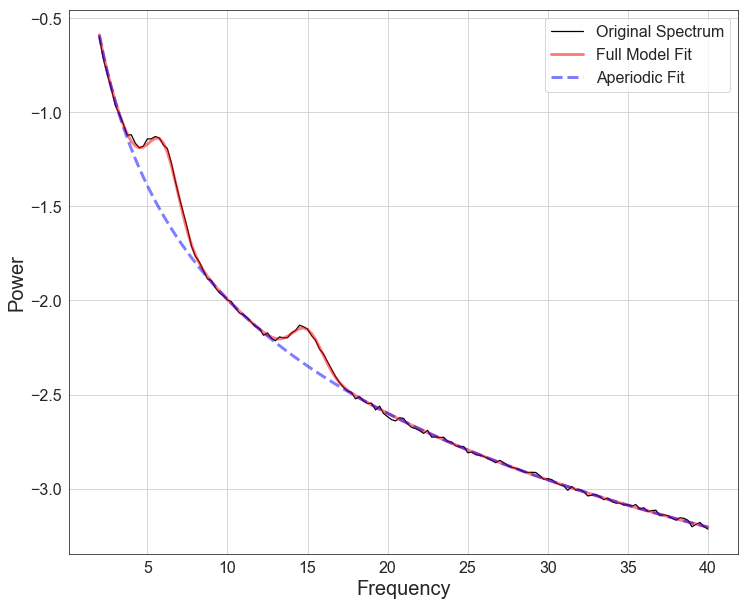

In [60]:
# Grab example case, plot & save out
ind = 1
fm = mp_fgs[2].get_fooof(ind, True)
print(mp_sim_params[2][ind])
fm.print_results()
fm.plot(save_fig=save_fig, file_path='plts', file_name='MultiPeak-2P')

SimParams(aperiodic_params=[0, 1.0], gaussian_params=[[9, 0.25, 3.0], [15, 0.15, 2.0], [19, 0.25, 2.0], [23, 0.4, 2.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.1037, 1.0615                                          
                                                                             

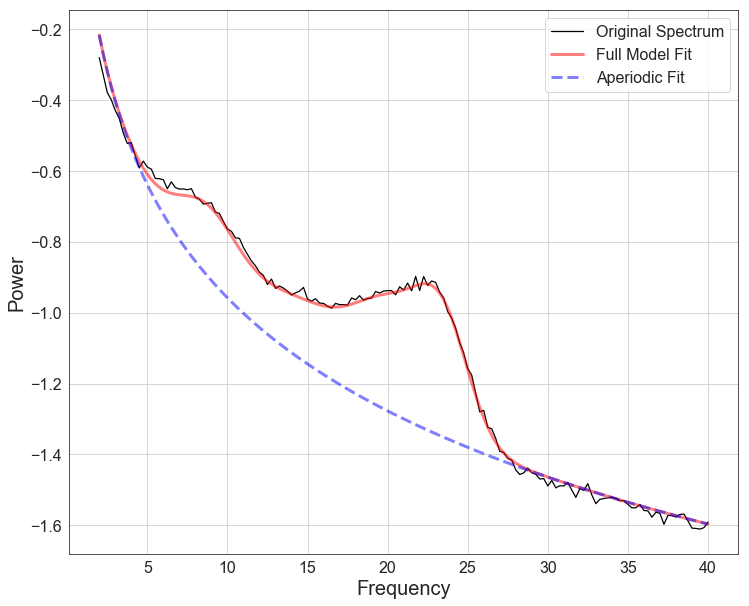

In [61]:
# Grab example case, plot & save out
ind = 10
fm = mp_fgs[-1].get_fooof(ind, True)
print(mp_sim_params[-1][ind])
fm.print_results()
fm.plot(save_fig=save_fig, file_path='plts', file_name='MultiPeak-4P')

### Check Fit Qualities

In [62]:
## Check fit across all 10,000 simulations
temp = np.concatenate([r2_fits_1p.flatten(), r2_fits.flatten()])

print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.4452 	1.0000
Median  R^2: 	0.9972
